Обучение логистической регрессии на корпусе А 

In [1]:
# Установка библиотек
%pip install pandas openpyxl scikit-learn joblib matplotlib seaborn -q

import pandas as pd
import numpy as np
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import os
from datetime import datetime




[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Пути к файлам
corpus_path = r"C:\Users\Sony\OneDrive\Рабочий стол\Переподготовка ВШЭ\проект\2\LOTR\17.02 corp\corp_a.xlsx"
nom_path = r"C:\Users\Sony\OneDrive\Рабочий стол\Переподготовка ВШЭ\проект\2\LOTR\17.02 corp\nom a.xlsx"

# Загружаем корпус А
df_corpus = pd.read_excel(corpus_path)
# Оставляем только нужные колонки
needed_cols = ['english', 'russian_1', 'russian_2', 'russian_3', 'nom.orig', 'nom.1', 'nom.2', 'nom.3']
existing_cols = [col for col in needed_cols if col in df_corpus.columns]
df_corpus = df_corpus[existing_cols]

print(f"Корпус А загружен: {df_corpus.shape[0]} строк, {df_corpus.shape[1]} колонок")
print(f"Колонки: {list(df_corpus.columns)}")

# Загружаем таблицу номинаций
df_nom = pd.read_excel(nom_path)
df_nom = df_nom.iloc[:, :4]  # берем первые 4 колонки
df_nom.columns = ['original', '1', '2', '3']  # переименовываем

print(f"\nТаблица номинаций загружена: {df_nom.shape[0]} строк")
print(f"Колонки: {list(df_nom.columns)}")
print("\nПервые 5 строк таблицы номинаций:")
print(df_nom.head())

Корпус А загружен: 2818 строк, 8 колонок
Колонки: ['english', 'russian_1', 'russian_2', 'russian_3', 'nom.orig', 'nom.1', 'nom.2', 'nom.3']

Таблица номинаций загружена: 416 строк
Колонки: ['original', '1', '2', '3']

Первые 5 строк таблицы номинаций:
         original                    1            2                 3
0  accursed Tower                  NaN          NaN   Проклятая Башня
1   accursed vale  околдованная долина          NaN  проклятая долина
2       Adventure          Приключение  Приключение       Приключение
3        Aglarond             Агларонд     Агларонд          Агларонд
4        Aldalómë            Аладоломэ    Альдаломэ          Алдаломэ


In [3]:
# Функция для поиска имени в тексте
def find_name_in_text(text, name_to_find):
    
    # Проверяем на пустые значения
    if pd.isna(text) or pd.isna(name_to_find) or not name_to_find:
        return False
    
    # Переводим в нижний регистр для сравнения
    text = str(text).lower()
    name_to_find = str(name_to_find).lower()
    
    # Простой поиск
    if name_to_find in text:
        return True
    
    # Если имя длинное, ищем по первым 4 буквам
    if len(name_to_find) > 4:
        base = name_to_find[:4]
        if base in text:
            return True
    
    return False

# Тестируем функцию
test_text = "Хоббиты встретили Гэндальфа"
test_name = "Гэндальф"
result = find_name_in_text(test_text, test_name)
print(f"Тест функции: '{test_name}' в '{test_text}' → {result}")

Тест функции: 'Гэндальф' в 'Хоббиты встретили Гэндальфа' → True


In [ ]:
# Создаем словарь для быстрого доступа к переводам
nom_dict = {}
for _, row in df_nom.iterrows():
    orig = row['original']
    nom_dict[orig] = {
        1: str(row['1']) if pd.notna(row['1']) and str(row['1']).strip() else None,
        2: str(row['2']) if pd.notna(row['2']) and str(row['2']).strip() else None,
        3: str(row['3']) if pd.notna(row['3']) and str(row['3']).strip() else None
    }

print(f"Загружено {len(nom_dict)} имен из таблицы номинаций")

# Создаем список для признаков
features_list = []
labels_list = []  # сюда будем сохранять, какой это переводчик (1, 2 или 3)

total_rows = len(df_corpus)

# Проходим по каждой строке корпуса
for idx, row in df_corpus.iterrows():
    if idx % 50 == 0:
        print(f"  Обработано строк: {idx}/{total_rows}")
    
    original_name = row['nom.orig']  # английское имя
    
    # Для каждого переводчика (1, 2, 3)
    for translator in [1, 2, 3]:
        text = row[f'russian_{translator}']  # текст переводчика
        nom_value = row[f'nom.{translator}']  # как он перевел имя
        
        # Пропускаем, если нет текста или перевода имени
        if pd.isna(text) or not str(text).strip() or pd.isna(nom_value) or not str(nom_value).strip():
            continue
        
        text = str(text)
        nom_value = str(nom_value)
        
        # Создаем признаки
        features = {
            # Мета-информация (не для обучения)
            'translator': translator,
            'original_name': original_name,
            'nom_value': nom_value,
            'row_id': idx,
            
            # ПРИЗНАК 1: длина текста
            'text_length': len(text),
            
            # ПРИЗНАК 2: количество слов
            'word_count': len(text.split()),
            
            # ПРИЗНАК 3: длина самого имени
            'nom_length': len(nom_value),
            
            # ПРИЗНАК 4: найдено ли имя в тексте
            'name_found': 1 if find_name_in_text(text, nom_value) else 0,
        }
        
        # ПРИЗНАКИ 5...N: для каждого имени из словаря
        # проверяем, встречается ли оно в тексте
        for nom_orig, translations in nom_dict.items():
            trans_val = translations[translator]
            
            if trans_val is None:
                continue
            
            # Создаем признак has_ИМЯ (например: has_Gandalf)
            feature_name = f'has_{nom_orig}'
            features[feature_name] = 1 if find_name_in_text(text, trans_val) else 0
        
        # Сохраняем признаки и метку (какой это переводчик)
        features_list.append(features)
        labels_list.append(translator)

print(f"\nСоздано признаков: {len(features_list)} примеров")

In [5]:
# Преобразуем список признаков в таблицу (DataFrame)
df_features = pd.DataFrame(features_list)

print(f"Размер таблицы признаков: {df_features.shape} (строк x столбцов)")
print(f"\nВсего колонок: {len(df_features.columns)}")
print(f"Первые 10 колонок: {df_features.columns[:10].tolist()}")

# Отделяем признаки от мета-информации
meta_cols = ['translator', 'original_name', 'nom_value', 'row_id']
X_cols = [col for col in df_features.columns if col not in meta_cols]

print(f"\nК-во признаков для обучения: {len(X_cols)}")
print(f"  - Признаков имён (has_*): {len([c for c in X_cols if c.startswith('has_')])}")
print(f"  - Базовых признаков: {len([c for c in X_cols if not c.startswith('has_')])}")

# Заполняем пустые значения нулями
df_features[X_cols] = df_features[X_cols].fillna(0)

# Создаем матрицу признаков X и целевую переменную y
X = df_features[X_cols]
y = np.array(labels_list)

print(f"\nРАЗМЕРНОСТЬ ДАННЫХ:")
print(f"  X (признаки): {X.shape}")
print(f"  y (метки): {y.shape}")

# Смотрим распределение переводчиков
unique, counts = np.unique(y, return_counts=True)
print("\nРАСПРЕДЕЛЕНИЕ ПЕРЕВОДЧИКОВ:")
for t, c in zip(unique, counts):
    print(f"  Переводчик {t}: {c} примеров ({c/len(y)*100:.1f}%)")

Размер таблицы признаков: (4922, 365) (строк x столбцов)

Всего колонок: 365
Первые 10 колонок: ['translator', 'original_name', 'nom_value', 'row_id', 'text_length', 'word_count', 'nom_length', 'name_found', 'has_accursed Tower', 'has_accursed vale']

К-во признаков для обучения: 361
  - Признаков имён (has_*): 357
  - Базовых признаков: 4

РАЗМЕРНОСТЬ ДАННЫХ:
  X (признаки): (4922, 361)
  y (метки): (4922,)

РАСПРЕДЕЛЕНИЕ ПЕРЕВОДЧИКОВ:
  Переводчик 1: 1865 примеров (37.9%)
  Переводчик 2: 1408 примеров (28.6%)
  Переводчик 3: 1649 примеров (33.5%)


In [6]:
# Делим данные на обучающую (80%) и тестовую (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,           # 20% на тест
    random_state=42,         # для воспроизводимости
    stratify=y               # сохраняем пропорции классов
)

print(f"Обучающая выборка: {X_train.shape[0]} примеров")
print(f"Тестовая выборка: {X_test.shape[0]} примеров")

# Проверяем распределение в тестовой выборке
unique_test, counts_test = np.unique(y_test, return_counts=True)
print("\nРАСПРЕДЕЛЕНИЕ В ТЕСТЕ:")
for t, c in zip(unique_test, counts_test):
    print(f"  Переводчик {t}: {c} примеров ({c/len(y_test)*100:.1f}%)")

Обучающая выборка: 3937 примеров
Тестовая выборка: 985 примеров

РАСПРЕДЕЛЕНИЕ В ТЕСТЕ:
  Переводчик 1: 373 примеров (37.9%)
  Переводчик 2: 282 примеров (28.6%)
  Переводчик 3: 330 примеров (33.5%)


In [7]:
# Создание модели логистической регрессии
log_model = LogisticRegression(
    max_iter=1000,           
    random_state=42,
    solver='lbfgs',          
    multi_class='ovr'       
)

print("Начинаем обучение логистической регрессии...")
log_model.fit(X_train, y_train)
print("Модель обучена!")

# Смотрим на важность признаков
coef_df = pd.DataFrame({
    'feature': X_cols,
    'coef_1': log_model.coef_[0],  # коэффициенты для класса 1
    'coef_2': log_model.coef_[1],  # коэффициенты для класса 2
    'coef_3': log_model.coef_[2],  # коэффициенты для класса 3
})

# Сортируем по модулю коэффициента (по важности)
coef_df['importance'] = np.abs(coef_df[['coef_1', 'coef_2', 'coef_3']]).mean(axis=1)
coef_df = coef_df.sort_values('importance', ascending=False)

print("\n10 самых важных признаков:")
print(coef_df.head(10).to_string(index=False))

Начинаем обучение логистической регрессии...


c:\Users\Sony\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Sony\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Модель обучена!

10 самых важных признаков:
                       feature    coef_1    coef_2    coef_3  importance
                  has_Hobbiton -5.295589  2.866062  2.456699    3.539450
                 has_West-gate -4.417012 -0.732295  4.276458    3.141922
                 has_West Wind  4.309690 -3.232866 -1.442128    2.994895
                      has_Dale  3.533733 -2.261632 -2.503880    2.766415
has_notice and a list of Rules -2.201444 -2.303943  3.324313    2.609900
             has_Great Barrows  3.456604 -3.947098  0.084231    2.495978
                has_Great Horn -3.009079 -0.694522  3.393531    2.365710
             has_black serpent  1.948197 -3.573741  1.334838    2.285592
                   has_Dimholt -2.179109 -1.681678  2.880338    2.247042
               has_White Rider -1.864326 -1.682740  3.160365    2.235811


In [8]:
# Предсказания на тестовой выборке
y_pred = log_model.predict(X_test)

# Считаем точность
accuracy = accuracy_score(y_test, y_pred)

print(f"РЕЗУЛЬТАТЫ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ")
print(f"Точность на тесте: {accuracy:.2%}")
print(f"(случайное угадывание: 33%)")
print()

# Детальный отчет
print("КЛАССИФИКАЦИОННЫЙ ОТЧЕТ:")
print(classification_report(y_test, y_pred, 
                          target_names=['Переводчик 1', 'Переводчик 2', 'Переводчик 3']))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
print("\nМАТРИЦА ОШИБОК:")
print("           ПРЕДСКАЗАНО")
print("          1    2    3")
for i, row in enumerate(cm, 1):
    print(f"Реально {i}: {row}")

РЕЗУЛЬТАТЫ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ
Точность на тесте: 67.61%
(случайное угадывание: 33%)

КЛАССИФИКАЦИОННЫЙ ОТЧЕТ:
              precision    recall  f1-score   support

Переводчик 1       0.68      0.81      0.74       373
Переводчик 2       0.58      0.65      0.61       282
Переводчик 3       0.79      0.55      0.65       330

    accuracy                           0.68       985
   macro avg       0.68      0.67      0.67       985
weighted avg       0.69      0.68      0.67       985


МАТРИЦА ОШИБОК:
           ПРЕДСКАЗАНО
          1    2    3
Реально 1: [302  46  25]
Реально 2: [ 75 183  24]
Реально 3: [ 64  85 181]


In [9]:
# Создаем папку для результатов
output_dir = r"C:\Users\Sony\OneDrive\Рабочий стол\Переподготовка ВШЭ\проект\2\LOTR\17.02 corp\results"
os.makedirs(output_dir, exist_ok=True)

# Создаем подпапку с датой и временем
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = os.path.join(output_dir, f"logreg_run_{timestamp}")
os.makedirs(run_dir, exist_ok=True)

print(f"СОХРАНЯЕМ РЕЗУЛЬТАТЫ В: {run_dir}")

# Сохраняем модель
model_path = os.path.join(run_dir, 'logistic_regression_model.pkl')
joblib.dump(log_model, model_path)
print(f" Модель сохранена")

# Сохраняем коэффициенты
coef_df.to_csv(os.path.join(run_dir, 'coefficients.csv'), index=False, encoding='utf-8-sig')
print(f" Коэффициенты сохранены")

# Сохраняем результаты теста
test_results = pd.DataFrame({
    'true': y_test,
    'pred': y_pred,
    'correct': y_test == y_pred
})

# Добавляем информацию об именах
test_indices = X_test.index
test_names = []
for idx in test_indices:
    if idx < len(features_list):
        test_names.append({
            'original': features_list[idx]['original_name'],
            'translation': features_list[idx]['nom_value']
        })
    else:
        test_names.append({'original': 'unknown', 'translation': 'unknown'})

test_results['original_name'] = [info['original'] for info in test_names]
test_results['translation'] = [info['translation'] for info in test_names]

test_results.to_excel(os.path.join(run_dir, 'test_results.xlsx'), index=False)
print(f" Результаты теста сохранены")

print(f"\nВсе файлы сохранены в папке:\n{run_dir}")

СОХРАНЯЕМ РЕЗУЛЬТАТЫ В: C:\Users\Sony\OneDrive\Рабочий стол\Переподготовка ВШЭ\проект\2\LOTR\17.02 corp\results\logreg_run_20260219_223728
 Модель сохранена
 Коэффициенты сохранены
 Результаты теста сохранены

Все файлы сохранены в папке:
C:\Users\Sony\OneDrive\Рабочий стол\Переподготовка ВШЭ\проект\2\LOTR\17.02 corp\results\logreg_run_20260219_223728


In [10]:
# Предсказываем переводчика для новых фрагментов текста
def predict_translator(model, text, df_nom, X_cols):
   
    # Создаем признаки для этого текста
    features = {}
    
    # Добавляем признаки для всех имён из словаря
    for _, nom_row in df_nom.iterrows():
        orig = nom_row['original']
        
        # Проверяем для всех трёх переводчиков
        found = False
        for t in [1,2,3]:
            trans = nom_row[str(t)]
            if pd.notna(trans) and trans and trans.lower() in text.lower():
                found = True
                break
        features[f'has_{orig}'] = 1 if found else 0
    
    # Добавляем базовые признаки
    features['text_length'] = len(text)
    features['word_count'] = len(text.split())
    features['nom_length'] = 0
    features['name_found'] = 1 if any(features.values()) else 0
    
    # Преобразуем в DataFrame
    X_pred = pd.DataFrame([features])
    
    # Добавляем недостающие колонки
    for col in X_cols:
        if col not in X_pred.columns:
            X_pred[col] = 0
    
    X_pred = X_pred[X_cols]
    
    # Предсказание
    pred = model.predict(X_pred)[0]
    proba = model.predict_proba(X_pred)[0]
    
    # Выводим результат
    print("ПРЕДСКАЗАНИЕ ДЛЯ НОВОГО ТЕКСТА")
    print(f"Текст: {text}")
    print(f"\nПредсказанный переводчик: {pred}")
    print("\nУверенность:")
    for i, p in enumerate(proba, 1):
        print(f"  Переводчик {i}: {p:.2%}")
    
    return pred, proba

# ТЕСТИРУЕМ ФУНКЦИЮ
test_text = "Гэндальф отправился в Шир и встретил там хоббитов"
pred, proba = predict_translator(log_model, test_text, df_nom, X_cols)

ПРЕДСКАЗАНИЕ ДЛЯ НОВОГО ТЕКСТА
Текст: Гэндальф отправился в Шир и встретил там хоббитов

Предсказанный переводчик: 1

Уверенность:
  Переводчик 1: 95.93%
  Переводчик 2: 2.04%
  Переводчик 3: 2.03%


In [11]:
# Путь к корпусу Б
corpus_b_path = r"C:\Users\Sony\OneDrive\Рабочий стол\Переподготовка ВШЭ\проект\2\LOTR\17.02 corp\corp_b.xlsx"

# Загружаем корпус Б
df_corpus_b = pd.read_excel(corpus_b_path)

# Оставляем нужные колонки
expected_cols = ['english', 'russian_1', 'russian_2', 'russian_3', 'nom.orig', 'nom.1', 'nom.2', 'nom.3']
existing_cols = [col for col in expected_cols if col in df_corpus_b.columns]
df_corpus_b = df_corpus_b[existing_cols]

print(f"Корпус Б загружен: {df_corpus_b.shape[0]} строк")
print(f"Колонки: {list(df_corpus_b.columns)}")

# Смотрим, есть ли пересечение имен с корпусом А
names_in_a = set(df_corpus['nom.orig'].unique()) if 'df_corpus' in dir() else set()
names_in_b = set(df_corpus_b['nom.orig'].unique())
overlap = names_in_a & names_in_b

print(f"\nИмена в корпусе А: {len(names_in_a)}")
print(f"Имена в корпусе Б: {len(names_in_b)}")
print(f"Пересечение: {len(overlap)}")
if len(overlap) == 0:
    print(" Имена новые (нет пересечений)")

Корпус Б загружен: 506 строк
Колонки: ['english', 'russian_1', 'russian_2', 'russian_3', 'nom.orig', 'nom.1', 'nom.2', 'nom.3']

Имена в корпусе А: 436
Имена в корпусе Б: 48
Пересечение: 0
 Имена новые (нет пересечений)


In [ ]:
# Подготавливает признаки для корпуса Б (новые имена)
def prepare_corpus_b(df_corpus_b, df_nom, X_cols):

    # Словарь номинаций
    nom_dict = {}
    for _, row in df_nom.iterrows():
        orig = row['original']
        nom_dict[orig] = {
            1: str(row['1']) if pd.notna(row['1']) and str(row['1']).strip() else None,
            2: str(row['2']) if pd.notna(row['2']) and str(row['2']).strip() else None,
            3: str(row['3']) if pd.notna(row['3']) and str(row['3']).strip() else None
        }
    
    print(f"Используем словарь с {len(nom_dict)} именами")
    
    features_list = []
    true_labels_list = []
    names_info_list = []
    
    total_rows = len(df_corpus_b)
    
    for idx, row in df_corpus_b.iterrows():
        if idx % 20 == 0:
            print(f"  Обработано: {idx}/{total_rows}")
        
        original_name = row['nom.orig']
        
        for translator in [1, 2, 3]:
            text = row[f'russian_{translator}']
            
            if pd.isna(text) or not str(text).strip():
                continue
            
            text = str(text)
            
            # Создаем признаки
            features = {
                'true_translator': translator,
                'original_name': original_name,
                'row_id': idx,
                'text_length': len(text),
                'word_count': len(text.split()),
                'name_found': 0,
                'nom_length': 0,
            }
            
            # Добавляем has_ признаки
            for nom_orig, translations in nom_dict.items():
                trans_val = translations[translator]
                
                if trans_val is None:
                    features[f'has_{nom_orig}'] = 0
                else:
                    features[f'has_{nom_orig}'] = 1 if find_name_in_text(text, trans_val) else 0
            
            # Переопределяем name_found
            name_features = [v for k, v in features.items() if k.startswith('has_')]
            features['name_found'] = 1 if any(name_features) else 0
            
            features_list.append(features)
            true_labels_list.append(translator)
            names_info_list.append({
                'original': original_name,
                'translator': translator
            })
    
    print(f"Подготовлено {len(features_list)} примеров")
    return features_list, true_labels_list, names_info_list

# Подготавливаем данные
features_list_b, true_labels_b, names_info_b = prepare_corpus_b(df_corpus_b, df_nom, X_cols)

In [13]:
# Создаем DataFrame из признаков
df_features_b = pd.DataFrame(features_list_b)

# Отделяем признаки от мета-информации
meta_cols = ['true_translator', 'original_name', 'row_id']
feature_cols_b = [col for col in df_features_b.columns if col not in meta_cols]

# Проверяем, все ли колонки есть
missing_cols = set(X_cols) - set(feature_cols_b)
if missing_cols:
    print(f"Добавляем недостающие колонки: {missing_cols}")
    for col in missing_cols:
        df_features_b[col] = 0

# Берем только нужные колонки в правильном порядке
X_b = df_features_b[X_cols]
y_b_true = df_features_b['true_translator'].values

print(f"Размер X_b: {X_b.shape}")
print(f"Размер y_b_true: {y_b_true.shape}")

# Предсказания
y_b_pred = log_model.predict(X_b)

# Считаем точность
accuracy_b = accuracy_score(y_b_true, y_b_pred)

print("РЕЗУЛЬТАТЫ НА КОРПУСЕ Б (НОВЫЕ ИМЕНА)")

print(f"Точность: {accuracy_b:.2%}")
print(f"(корпус А: {accuracy:.2%})")
print(f"Разница: {accuracy_b - accuracy:+.2%}")

# Матрица ошибок
cm_b = confusion_matrix(y_b_true, y_b_pred)
print("\nМАТРИЦА ОШИБОК:")
print("          1    2    3")
for i, row in enumerate(cm_b, 1):
    print(f"Реально {i}: {row}")

Размер X_b: (1518, 361)
Размер y_b_true: (1518,)
РЕЗУЛЬТАТЫ НА КОРПУСЕ Б (НОВЫЕ ИМЕНА)
Точность: 64.30%
(корпус А: 67.61%)
Разница: -3.32%

МАТРИЦА ОШИБОК:
          1    2    3
Реально 1: [359 137  10]
Реально 2: [128 357  21]
Реально 3: [ 68 178 260]


In [14]:
# Путь к корпусу С
corpus_c_path = r"C:\Users\Sony\OneDrive\Рабочий стол\Переподготовка ВШЭ\проект\2\LOTR\17.02 corp\corp_с_masked.xlsx"

# Загружаем корпус С
df_corpus_c = pd.read_excel(corpus_c_path)

# Оставляем нужные колонки
expected_cols_c = ['english', 'russian_1', 'russian_2', 'russian_3']
existing_cols_c = [col for col in expected_cols_c if col in df_corpus_c.columns]
df_corpus_c = df_corpus_c[existing_cols_c]

print(f"Корпус С загружен: {df_corpus_c.shape[0]} строк")
print(f"Колонки: {list(df_corpus_c.columns)}")

# Показываем пример замаскированного текста
if len(df_corpus_c) > 0:
    print(f"\nПример замаскированного текста:")
    print(df_corpus_c['russian_1'].iloc[0][:200] + "...")

Корпус С загружен: 374 строк
Колонки: ['english', 'russian_1', 'russian_2', 'russian_3']

Пример замаскированного текста:
А утром над шпилем [nom] развевалось знамя [nom], голубое с белым кораблем, подобным лебедю; [nom] смотрели на него и думали – неужто приснилось им явленье [nom]?...


In [ ]:
# Подготавливаем признаки для корпуса С (все имена заменены на [nom])
def prepare_corpus_c(df_corpus_c, df_nom, X_cols):
  
    # Словарь номинаций (нужен только для структуры)
    nom_dict = {}
    for _, row in df_nom.iterrows():
        orig = row['original']
        nom_dict[orig] = {
            1: str(row['1']) if pd.notna(row['1']) and str(row['1']).strip() else None,
            2: str(row['2']) if pd.notna(row['2']) and str(row['2']).strip() else None,
            3: str(row['3']) if pd.notna(row['3']) and str(row['3']).strip() else None
        }
    
    print(f"Словарь содержит {len(nom_dict)} имен")
    print("В тексте все имена замаскированы → все has_* = 0")
    
    features_list = []
    true_labels_list = []
    text_samples_list = []
    
    total_rows = len(df_corpus_c)
    
    for idx, row in df_corpus_c.iterrows():
        if idx % 20 == 0:
            print(f"  Обработано: {idx}/{total_rows}")
        
        for translator in [1, 2, 3]:
            text = row[f'russian_{translator}']
            
            if pd.isna(text) or not str(text).strip():
                continue
            
            text = str(text)
            
            # Создаем признаки (все has_ = 0, т.к. имена замаскированы)
            features = {
                'true_translator': translator,
                'row_id': idx,
                'text_length': len(text),
                'word_count': len(text.split()),
                'name_found': 0,
                'nom_length': 0,
            }
            
            # Все has_ признаки = 0
            for nom_orig in nom_dict.keys():
                features[f'has_{nom_orig}'] = 0
            
            features_list.append(features)
            true_labels_list.append(translator)
            text_samples_list.append(text[:100] + "...")
    
    print(f"Подготовлено {len(features_list)} примеров")
    return features_list, true_labels_list, text_samples_list

# Подготавливаем данные
features_list_c, true_labels_c, text_samples_c = prepare_corpus_c(df_corpus_c, df_nom, X_cols)

In [16]:
# Создаем DataFrame
df_features_c = pd.DataFrame(features_list_c)

# Отделяем признаки
meta_cols_c = ['true_translator', 'row_id']
feature_cols_c = [col for col in df_features_c.columns if col not in meta_cols_c]

# Добавляем недостающие колонки
missing_cols_c = set(X_cols) - set(feature_cols_c)
if missing_cols_c:
    for col in missing_cols_c:
        df_features_c[col] = 0

# Берем только нужные колонки
X_c = df_features_c[X_cols]
y_c_true = df_features_c['true_translator'].values

# Проверяем, что все has_ признаки = 0
has_cols = [col for col in X_cols if col.startswith('has_')]
if len(has_cols) > 0:
    sample_has = X_c[has_cols].iloc[0]
    print(f"Проверка: все has_ признаки = {sample_has.unique()}")

print(f"Размер X_c: {X_c.shape}")

# Предсказания
y_c_pred = log_model.predict(X_c)

# Точность
accuracy_c = accuracy_score(y_c_true, y_c_pred)


print("РЕЗУЛЬТАТЫ НА КОРПУСЕ С (БЕЗ ИМЕН)")

print(f"Точность: {accuracy_c:.2%}")

# Матрица ошибок
cm_c = confusion_matrix(y_c_true, y_c_pred)
print("\nМАТРИЦА ОШИБОК:")
print("          1    2    3")
for i, row in enumerate(cm_c, 1):
    print(f"Реально {i}: {row}")

Проверка: все has_ признаки = [0]
Размер X_c: (1122, 361)
РЕЗУЛЬТАТЫ НА КОРПУСЕ С (БЕЗ ИМЕН)
Точность: 33.87%

МАТРИЦА ОШИБОК:
          1    2    3
Реально 1: [  9 365   0]
Реально 2: [  3 371   0]
Реально 3: [  3 371   0]


In [17]:
print("ИТОГОВОЕ СРАВНЕНИЕ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ")

# Создаем таблицу сравнения
comparison = pd.DataFrame({
    'Корпус': ['А (знакомые имена)', 'Б (новые имена)', 'С (без имен)'],
    'Точность %': [accuracy*100, accuracy_b*100, accuracy_c*100],
    'Описание': [
        'Имена были в обучении',
        'Совершенно новые имена',
        'Все имена заменены на [nom]'
    ]
})

print(comparison.to_string(index=False))


# Считаем вклад разных факторов
contribution_names = (accuracy - accuracy_b) * 100
contribution_strategy = (accuracy_b - accuracy_c) * 100
contribution_style = accuracy_c * 100

print(f"""
Из 100% узнавания переводчика:

• Конкретные имена:           {contribution_names:.1f}%
  (разница между А и Б)

• Стратегии перевода имен:    {contribution_strategy:.1f}%
  (разница между Б и С)

• Только стиль текста:        {contribution_style:.1f}%
  (точность на корпусе С)
""")

# Интерпретация
print("\nВЫВОД:")
if accuracy_c > 0.5:
    print(" У переводчиков сильный стилистический почерк")
    print("  Их можно узнать даже без номинаций")
elif accuracy_c > 0.45:
    print(" Хороший стилистический почерк")
    print("  Номинации важны, но стиль тоже хорошо различим")
elif accuracy_c > 0.4:
    print("  Основные различия - в переводе имен")
else:
    print("  Без номинаций переводчики почти неразличимы")

ИТОГОВОЕ СРАВНЕНИЕ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ
            Корпус  Точность %                    Описание
А (знакомые имена)   67.614213       Имена были в обучении
   Б (новые имена)   64.295125      Совершенно новые имена
      С (без имен)   33.868093 Все имена заменены на [nom]

Из 100% узнавания переводчика:

• Конкретные имена:           3.3%
  (разница между А и Б)

• Стратегии перевода имен:    30.4%
  (разница между Б и С)

• Только стиль текста:        33.9%
  (точность на корпусе С)


ВЫВОД:
  Без номинаций переводчики почти неразличимы


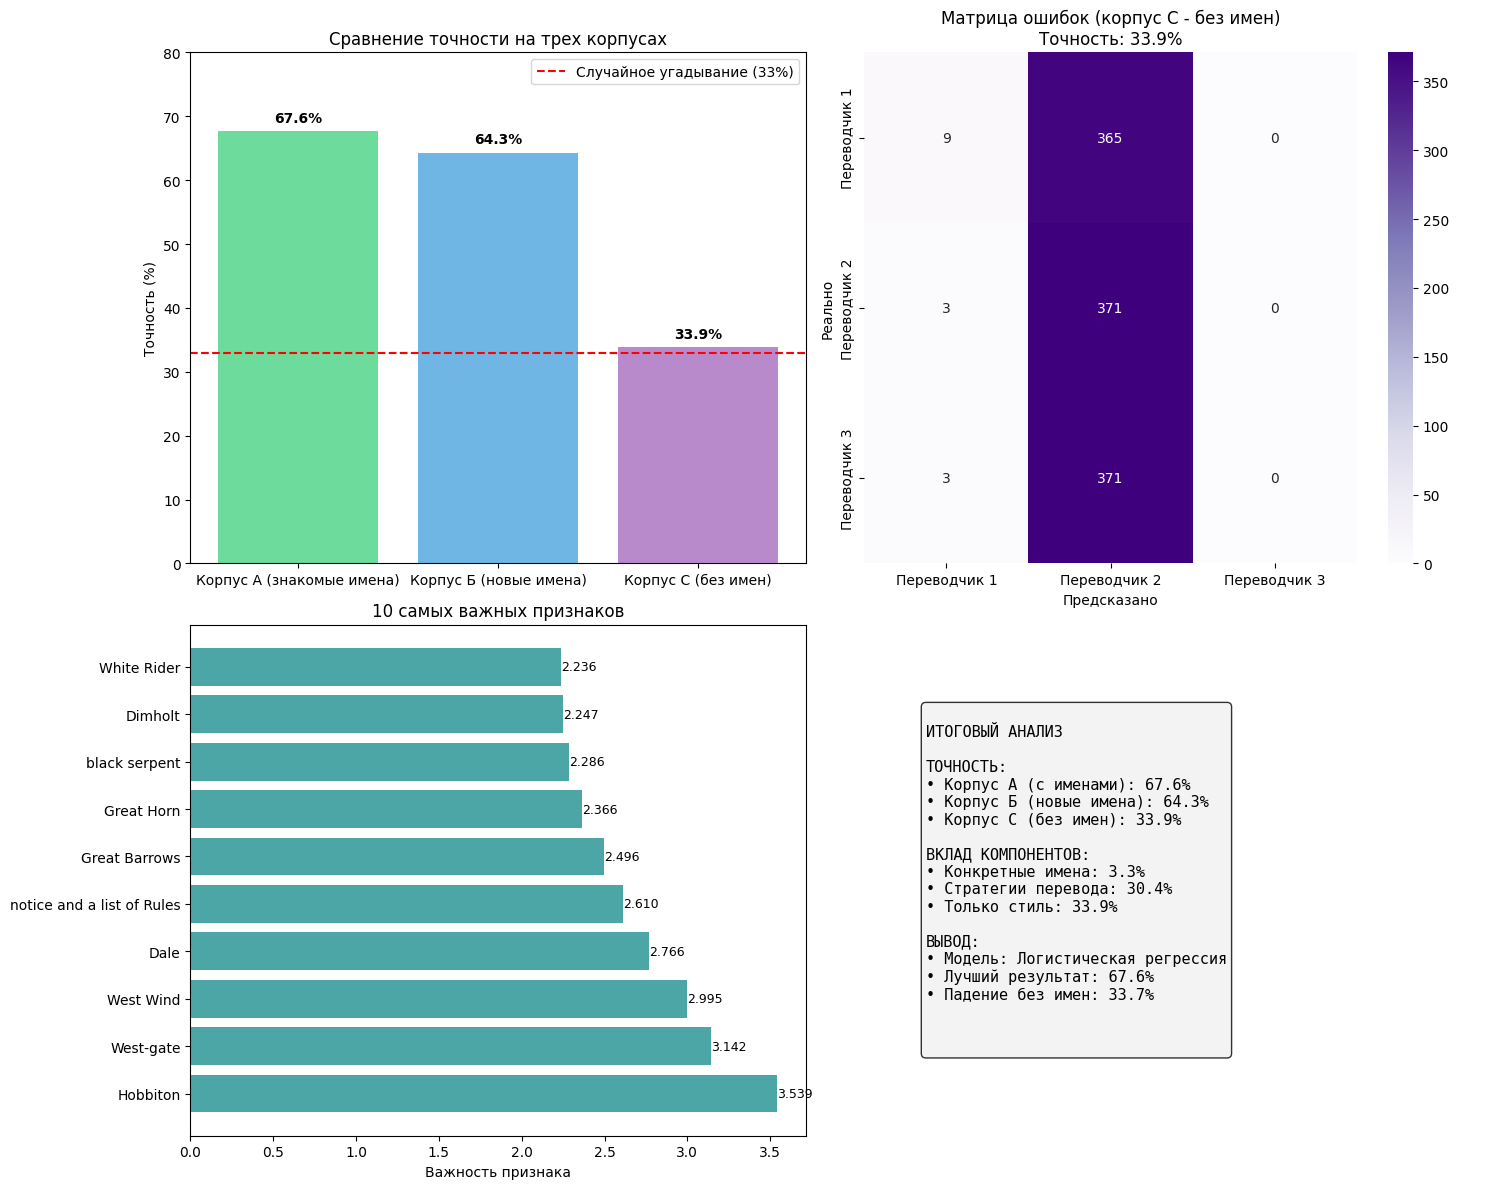

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
    
    # Создаем фигуру
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Сравнение точности
ax1 = axes[0, 0]
corpora = ['Корпус А (знакомые имена)', 'Корпус Б (новые имена)', 'Корпус С (без имен)']
accs = [accuracy*100, accuracy_b*100, accuracy_c*100]
colors = ['#2ecc71', '#3498db', '#9b59b6']
    
bars = ax1.bar(corpora, accs, color=colors, alpha=0.7)
ax1.axhline(y=33, color='red', linestyle='--', label='Случайное угадывание (33%)')
ax1.set_ylabel('Точность (%)')
ax1.set_title('Сравнение точности на трех корпусах')
ax1.set_ylim(0, 80)
ax1.legend()
    
for bar, acc in zip(bars, accs):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 2. Матрица ошибок для корпуса С
ax2 = axes[0, 1]
sns.heatmap(cm_c, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Переводчик 1', 'Переводчик 2', 'Переводчик 3'],
            yticklabels=['Переводчик 1', 'Переводчик 2', 'Переводчик 3'],
            ax=ax2)
ax2.set_title(f'Матрица ошибок (корпус С - без имен)\nТочность: {accuracy_c:.1%}')
ax2.set_xlabel('Предсказано')
ax2.set_ylabel('Реально')
    
    # 3. Коэффициенты модели (топ-10 самых важных признаков)
ax3 = axes[1, 0]
top_features = coef_df.head(10).copy()
    
    # Делаем названия признаков короче для читаемости
short_names = []
for name in top_features['feature'].values:
    if name.startswith('has_'):
        short_names.append(name[4:])  # убираем 'has_'
    else:
        short_names.append(name)
    
bars = ax3.barh(range(len(top_features)), top_features['importance'].values, color='teal', alpha=0.7)
ax3.set_yticks(range(len(top_features)))
ax3.set_yticklabels(short_names)
ax3.set_xlabel('Важность признака')
ax3.set_title('10 самых важных признаков')
    
    # Добавляем значения на график
for i, (bar, val) in enumerate(zip(bars, top_features['importance'].values)):
    ax3.text(val + 0.001, i, f'{val:.3f}', va='center', fontsize=9)
    
    # 4. Текстовый анализ (вывод)
ax4 = axes[1, 1]
ax4.axis('off')
    
    # Рассчитываем вклад разных факторов
contribution_names = (accuracy - accuracy_b) * 100
contribution_strategy = (accuracy_b - accuracy_c) * 100
contribution_style = accuracy_c * 100
    
text_analysis = f"""
ИТОГОВЫЙ АНАЛИЗ

ТОЧНОСТЬ:
• Корпус А (с именами): {accuracy*100:.1f}%
• Корпус Б (новые имена): {accuracy_b*100:.1f}%
• Корпус С (без имен): {accuracy_c*100:.1f}%
    
ВКЛАД КОМПОНЕНТОВ:
• Конкретные имена: {contribution_names:.1f}%
• Стратегии перевода: {contribution_strategy:.1f}%
• Только стиль: {contribution_style:.1f}%
    
ВЫВОД:
• Модель: Логистическая регрессия
• Лучший результат: {max(accs):.1f}%
• Падение без имен: {accuracy*100 - accuracy_c*100:.1f}%
    

"""
    
ax4.text(0.1, 0.5, text_analysis, fontsize=11, 
        va='center', family='monospace',
        bbox=dict(boxstyle='round', facecolor='#f0f0f0', alpha=0.8))
    
plt.tight_layout()
plt.show()
    
